In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression as LinearModel
import copy
import math
import pandas 
from utils import *

In [2]:

# This function selects the ranking constructed by the optimal rankings under fixed attention spans 
# + greedily filling the rest by adding the rest of the product 

def ApproxOpt_Greedy(r,p,G):
    
    M = len(G)
    
    sigma = AssortOpt(r,p,M)
    ## We need to greedly fill the rest slots for each display
    
    n = len(r)
    N = range(n)
    #expected_reward = r*p  # expected reward for each element 
    
    max_idx = 0

    lower_bound = 0
    
    H = []
    
    for key,values in sigma.items():
        
        R = values[0]
        best_k_display = values[1]
        
        if len(best_k_display) > 1:
            best_k_display.reverse()
        #print(best_k_display)
        last_elem = best_k_display[-1]
        rest_display = [i for i in range(last_elem +1, last_elem +  M - key )]
        
        this_display = best_k_display + rest_display
        #print(this_display)
        true_reward = TrueReward(this_display,r,p,G)
        
        H.append(R)
        if true_reward >= lower_bound: 
            
            max_idx = key
            
            lower_bound = true_reward
                 
    result = sigma[max_idx][1] 
    
    return result,lower_bound,H,sigma[M-1]


In [3]:
import time

def ApproxOpt_new(r,p,G):
    
    M = len(G)
    
    sigma = AssortOpt(r,p,M)
    
    max_idx = 0

    lower_bound = 0
    
    H = []
    
    for key,values in sigma.items():
        
        R = values[0]
        H.append(R)
        if R*G[key] >= lower_bound: 
            
            max_idx = key
            
            lower_bound = R*G[key]
            
            
    
    return sigma,H,sigma[M-1]
    

def GreedyHillClimb(r,p,G,this_ranking):
    
    M = len(G)
    n = len(r)
    
    res = []
    res.append(this_ranking)
    
    for x in range(1,M): # current length x, extend to x+1
        
        max_rev = 0
        for i in range(N):
            this_ranking = np.array(this_ranking)
            this_ranking = this_ranking.astype(int)
            #print(this_ranking)
            if i not in this_ranking:
                
                for j in range(min(x+1,3)):   # j = 0,1,...,x
                    
                    temp_ranking = np.zeros(x+1)
                    temp_ranking[0:j] = copy.deepcopy(this_ranking[0:j])
                    temp_ranking[j] = int(i)
                    temp_ranking[j+1:x+1] = copy.deepcopy(this_ranking[j:x])

                    
                    temp_ranking = np.array(temp_ranking)
                    temp_ranking = temp_ranking.astype(int)
                    #print(temp_ranking)
                    temp_rev = TrueReward(temp_ranking,r[temp_ranking],p[temp_ranking],G)

                    if temp_rev > max_rev:
                        next_ranking = copy.deepcopy(temp_ranking)
                        max_rev = temp_rev 
                        
        this_ranking = copy.deepcopy(next_ranking) 
        res.append(this_ranking)
        
        
    return this_ranking

N = 100
M = 20
K = 1000



random.seed(30)
np.random.seed(0) 

ratio1 = []
ratio1_profit = []
ratio1_choice = []
ratio1_rdm = []
ratio1_spanM = []
ratio1_maxExpProfit = []
ratio1_Greedy_Hill_Climbing = []
select_X1 = []

ratio2 = []
ratio2_profit = []
ratio2_choice = []
ratio2_rdm = []
ratio2_spanM = []
ratio2_maxExpProfit = []
ratio2_Greedy_Hill_Climbing = []
select_X2 = []

ratio3 = []
ratio3_profit = []
ratio3_choice = []
ratio3_rdm = []
ratio3_spanM = []
ratio3_maxExpProfit = []
ratio3_Greedy_Hill_Climbing = []
select_X3 = []

G1 = [1-i/M  for i in range(M)]
print(f"Distribution of attention span G1 = \n{G1}")
G2 = [0.9**i for i in range(M)]
print(f"Distribution of attention span G2 = \n {G2}")
    
## decreasing failure rate 
h3 = [0.1 - 0.05*i/M for i in range(M)]
h = 1 
G3 = [h]
for i in range(M):
    h = h*(1-h3[i])
    G3.append(h)
print(f"Distribution of attention span G3 = \n {G3}")


start = time.time()


for k in range(K):
    r = np.random.rand(N)*10
    r_sorted = np.sort(r)[::-1];
    r = r_sorted;

    p = np.random.rand(N)*0.5
    p = np.sort(p)



    S_profit = [i for i in range(M)] 
    S_choice = p.argsort()[-M:][::-1]
    S_choice.sort()
    
    S_rdm = random.sample(range(0,N),M)
    S_rdm.sort()
    
    ExpProfit = r*p
    
    S_ExpProfit = ExpProfit.argsort()[::-1][:M]
    
    #print(S_GreedyHill, r[S_GreedyHill]*p[S_GreedyHill])
    
    S_ExpProfit = copy.deepcopy(S_ExpProfit).astype(int)
    S_GreedyHill = GreedyHillClimb(r,p,G1,[S_ExpProfit[0]])
    

    if k % 10 == 0:
        end = time.time()
        print(f"The time of execution of {k} simulations is :", end-start)
    
    
    sigma, H, Sigma = ApproxOpt_new(r,p,G1)
    
    UB_1 = UpperBound(H,G1)
    
    idx_X = 0
    
    for i in range(M):
        
        this_S = sigma[i][1]
        this_S.reverse()
        
        s_plus= list(set(S_GreedyHill) - set(this_S)) 

        this_S += s_plus
        this_S = this_S[0:M]
        this_reward = float(TrueReward(this_S,r[this_S],p[this_S],G1))
        
        if i == 0 :
            max_reward = this_reward
            S = this_S
        else: 
            if this_reward > max_reward:
                max_reward = this_reward
                S = this_S
                idx_X = i
    select_X1.append((idx_X+1))            
    # ratio for ApproxOpt / UB
    ratio1.append(float(TrueReward(S,r[S],p[S],G1)/UB_1))
        
    # ratio for baseline algorithms 
    
    ratio1_profit.append(TrueReward(S_profit,r[S_profit],p[S_profit],G1)/UB_1)
    
    ratio1_choice.append(TrueReward(S_choice,r[S_choice],p[S_choice],G1)/UB_1)
    
    ratio1_rdm.append(TrueReward(S_rdm,r[S_rdm],p[S_rdm],G1)/UB_1)
    
    ratio1_spanM.append(TrueReward(Sigma[1],r[Sigma[1]],p[Sigma[1]],G1)/UB_1)
    
    ratio1_maxExpProfit.append(TrueReward(S_ExpProfit,r[S_ExpProfit],p[S_ExpProfit],G1)/UB_1)
    ratio1_Greedy_Hill_Climbing.append(TrueReward(S_GreedyHill,r[S_GreedyHill],p[S_GreedyHill],G1)/UB_1)    
    UB_1 = 0
    
    
    # geometric distributed span 

    sigma,H,  Sigma = ApproxOpt_new(r,p,G2)
    S_GreedyHill = GreedyHillClimb(r,p,G2,[S_ExpProfit[0]])       
    idx_X = 0
    for i in range(M):
        
        this_S = sigma[i][1]
        this_S.reverse()
        
        
        
        s_plus= list(set(S_GreedyHill) - set(this_S)) 
        
        this_S += s_plus
        this_S = this_S[0:M]
        this_reward = TrueReward(this_S,r[this_S],p[this_S],G2)
        
        if i == 0 :
            max_reward = this_reward
            S = this_S
        else: 
            if this_reward > max_reward:
                max_reward = this_reward
                S = this_S
                idx_X = i
    
    select_X2.append((idx_X+1))  
    # calculate upper bound  
    UB_2 = UpperBound(H,G2)
    
    ratio2.append(float(TrueReward(S,r[S],p[S],G2)/UB_2))
    # ratio for baseline algorithms 
    ratio2_profit.append(TrueReward(S_profit,r[S_profit],p[S_profit],G2)/UB_2)
    ratio2_choice.append(TrueReward(S_choice,r[S_choice],p[S_choice],G2)/UB_2)
    ratio2_rdm.append(TrueReward(S_rdm,r[S_rdm],p[S_rdm],G2)/UB_2)
    ratio2_spanM.append(TrueReward(Sigma[1],r[Sigma[1]],p[Sigma[1]],G2)/UB_2)
    ratio2_maxExpProfit.append(TrueReward(S_ExpProfit,r[S_ExpProfit],p[S_ExpProfit],G2)/UB_2)
    ratio2_Greedy_Hill_Climbing.append(TrueReward(S_GreedyHill,r[S_GreedyHill],p[S_GreedyHill],G2)/UB_2)
    UB_2 = 0


    sigma,H,  Sigma = ApproxOpt_new(r,p,G3)
    S_GreedyHill = GreedyHillClimb(r,p,G3,[S_ExpProfit[0]])       
    idx_X = 0
    for i in range(M):
        
        this_S = sigma[i][1]
        this_S.reverse()
        
        
        
        s_plus= list(set(S_GreedyHill) - set(this_S)) 
        
        this_S += s_plus
        this_S = this_S[0:M]
        this_reward = TrueReward(this_S,r[this_S],p[this_S],G3)
        
        if i == 0 :
            max_reward = this_reward
            S = this_S
        else: 
            if this_reward > max_reward:
                max_reward = this_reward
                S = this_S
                idx_X = i
    
    select_X3.append((idx_X+1))  
    # calculate upper bound  
    UB_3 = UpperBound(H,G3)
    
    ratio3.append(float(TrueReward(S,r[S],p[S],G3)/UB_3))
    # ratio for baseline algorithms 
    ratio3_profit.append(TrueReward(S_profit,r[S_profit],p[S_profit],G3)/UB_3)
    ratio3_choice.append(TrueReward(S_choice,r[S_choice],p[S_choice],G3)/UB_3)
    ratio3_rdm.append(TrueReward(S_rdm,r[S_rdm],p[S_rdm],G3)/UB_3)
    ratio3_spanM.append(TrueReward(Sigma[1],r[Sigma[1]],p[Sigma[1]],G3)/UB_3)
    ratio3_maxExpProfit.append(TrueReward(S_ExpProfit,r[S_ExpProfit],p[S_ExpProfit],G3)/UB_3)
    ratio3_Greedy_Hill_Climbing.append(TrueReward(S_GreedyHill,r[S_GreedyHill],p[S_GreedyHill],G3)/UB_3)
    UB_3 = 0
    
    

Distribution of attention span G1 = 
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.44999999999999996, 0.4, 0.35, 0.30000000000000004, 0.25, 0.19999999999999996, 0.15000000000000002, 0.09999999999999998, 0.050000000000000044]
Distribution of attention span G2 = 
 [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561, 0.5904900000000001, 0.531441, 0.4782969000000001, 0.4304672100000001, 0.3874204890000001, 0.3486784401000001, 0.31381059609000006, 0.2824295364810001, 0.2541865828329001, 0.2287679245496101, 0.20589113209464907, 0.18530201888518416, 0.16677181699666577, 0.15009463529699918, 0.13508517176729928]
Distribution of attention span G3 = 
 [1, 0.9, 0.81225, 0.73508625, 0.667090771875, 0.60705260240625, 0.5539354996957031, 0.5068509822215683, 0.46503577618828895, 0.4278329140932259, 0.39467586325100085, 0.3650751735071758, 0.33860722342790556, 0.31490471778795215, 0.29364864933726537, 0.2745614871303431, 0.25740139418469665, 0.24195731053361483, 0.22804476517793199, 0.2155023

In [6]:
qs = [0,0.25,0.5,0.75,1]

In [7]:
print("Summarizing stats under distribution G1")
print("The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: \n")
print(np.mean(ratio1), np.mean(ratio1_rdm), np.mean(ratio1_spanM), np.mean(ratio1_maxExpProfit), np.mean(ratio1_Greedy_Hill_Climbing))
print(f"The quantiles for ratio1 is {np.quantile(ratio1, qs)}")
print(f"The quantiles for ratio1_rdm is {np.quantile(ratio1_rdm, qs)}")
print(f"The quantiles for ratio1_spanM is {np.quantile(ratio1_spanM, qs)}")
print(f"The quantiles for ratio1_maxExpProfit is {np.quantile(ratio1_maxExpProfit, qs)}")
print(f"The quantiles for ratio1_Greedy_Hill_Climbing is {np.quantile(ratio1_Greedy_Hill_Climbing, qs)}")

Summarizing stats under distribution G1
The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: 

0.9391973884517243 0.7927994921993311 0.8497432815434935 0.7938802437465565 0.9225581305976336
The quantiles for ratio1 is [0.8878446  0.92928191 0.93969555 0.95020344 0.97772427]
The quantiles for ratio1_rdm is [0.59745476 0.75880444 0.79630838 0.83097831 0.92791913]
The quantiles for ratio1_spanM is [0.71934998 0.82881416 0.84924452 0.86993809 0.93940846]
The quantiles for ratio1_maxExpProfit is [0.53958811 0.74599448 0.79950065 0.84911307 0.9531537 ]
The quantiles for ratio1_Greedy_Hill_Climbing is [0.87034832 0.91432206 0.9235601  0.93223733 0.96020417]


In [8]:
print("Summarizing stats under distribution G2")
print("The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: \n")
print(np.mean(ratio2), np.mean(ratio2_rdm), np.mean(ratio2_spanM), np.mean(ratio2_maxExpProfit), np.mean(ratio2_Greedy_Hill_Climbing))
print(f"The quantiles for ratio2 is {np.quantile(ratio2, qs)}")
print(f"The quantiles for ratio2_rdm is {np.quantile(ratio2_rdm, qs)}")
print(f"The quantiles for ratio2_spanM is {np.quantile(ratio2_spanM, qs)}")
print(f"The quantiles for ratio2_maxExpProfit is {np.quantile(ratio2_maxExpProfit, qs)}")
print(f"The quantiles for ratio2_Greedy_Hill_Climbing is {np.quantile(ratio2_Greedy_Hill_Climbing, qs)}")

Summarizing stats under distribution G2
The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: 

0.9255584260883313 0.7317311624802425 0.8008066639279451 0.8157606512199354 0.91753393182854
The quantiles for ratio2 is [0.86379057 0.91254031 0.92715137 0.93927505 0.9762967 ]
The quantiles for ratio2_rdm is [0.51829684 0.68509103 0.7352452  0.77967055 0.90278789]
The quantiles for ratio2_spanM is [0.64678752 0.77543433 0.80025385 0.82567424 0.91384341]
The quantiles for ratio2_maxExpProfit is [0.575864   0.77244334 0.82052821 0.86701132 0.95720636]
The quantiles for ratio2_Greedy_Hill_Climbing is [0.86671586 0.90901714 0.91891142 0.9282767  0.95690278]


In [9]:
print("Summarizing stats under distribution G3")
print("The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: \n")
print(np.mean(ratio3), np.mean(ratio3_rdm), np.mean(ratio3_spanM), np.mean(ratio3_maxExpProfit), np.mean(ratio3_Greedy_Hill_Climbing))
print(f"The quantiles for ratio3 is {np.quantile(ratio3, qs)}")
print(f"The quantiles for ratio3_rdm is {np.quantile(ratio3_rdm, qs)}")
print(f"The quantiles for ratio3_spanM is {np.quantile(ratio3_spanM, qs)}")
print(f"The quantiles for ratio3_maxExpProfit is {np.quantile(ratio3_maxExpProfit, qs)}")
print(f"The quantiles for ratio3_Greedy_Hill_Climbing is {np.quantile(ratio3_Greedy_Hill_Climbing, qs)}")

Summarizing stats under distribution G3
The mean ratios for best-X, rdm, max_spanM, max_ExpProfit, max_GreedyHillClimbing are: 

0.916762094060435 0.7357523230390282 0.8516945191245179 0.7988063313580597 0.9131655473175864
The quantiles for ratio3 is [0.85185854 0.9034641  0.91786804 0.93080729 0.96813164]
The quantiles for ratio3_rdm is [0.55263302 0.69390667 0.73778724 0.77827356 0.89793051]
The quantiles for ratio3_spanM is [0.71582055 0.82732032 0.85230175 0.87861437 0.9445152 ]
The quantiles for ratio3_maxExpProfit is [0.55873306 0.75434836 0.80391442 0.84992591 0.94792968]
The quantiles for ratio3_Greedy_Hill_Climbing is [0.8597102  0.90422732 0.91445347 0.92354609 0.95334806]


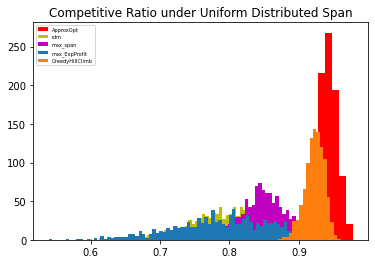

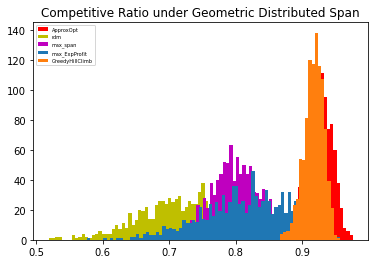

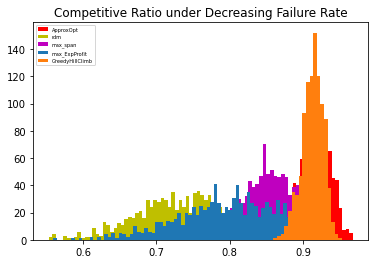

In [10]:
plt.figure
plt.hist(ratio1,bins = math.ceil((max(ratio1) - min(ratio1))/0.01),label =  "ApproxOpt", color = 'r')
#plt.hist(ratio1_profit,bins = math.ceil((max(ratio1_profit) - min(ratio1_profit))/0.005),label =  "max_Profit",color = 'b')
#plt.hist(ratio1_choice,bins = math.ceil((max(ratio1_choice) - min(ratio1_choice))/0.005),label =  "max_Choice",color = 'g')
plt.hist(ratio1_rdm,bins = math.ceil((max(ratio1_rdm) - min(ratio1_rdm))/0.005),label =  "rdm",color = 'y')
plt.hist(ratio1_spanM,bins = math.ceil((max(ratio1_spanM) - min(ratio1_spanM))/0.005),label =  "max_span",color = 'm')
plt.hist(ratio1_maxExpProfit,bins = math.ceil((max(ratio1_maxExpProfit) - min(ratio1_maxExpProfit))/0.005),label =  "max_ExpProfit")
plt.hist(ratio1_Greedy_Hill_Climbing,bins = math.ceil((max(ratio1_Greedy_Hill_Climbing) - min(ratio1_Greedy_Hill_Climbing))/0.005),label =  "GreedyHillClimb")


plt.legend(fontsize = 5, loc='upper left')
plt.title("Competitive Ratio under Uniform Distributed Span")
plt.show()

plt.figure
plt.hist(ratio2,bins = math.ceil((max(ratio2) - min(ratio2))/0.005),label =  "ApproxOpt", color = 'r')
#plt.hist(ratio2_profit,bins = math.ceil((max(ratio2_profit) - min(ratio2_profit))/0.005),label =  "max_Profit",color = 'b')
#plt.hist(ratio2_choice,bins = math.ceil((max(ratio2_choice) - min(ratio2_choice))/0.005),label =  "max_Choice",color = 'g')
plt.hist(ratio2_rdm,bins = math.ceil((max(ratio2_rdm) - min(ratio2_rdm))/0.005),label =  "rdm",color = 'y')
plt.hist(ratio2_spanM,bins = math.ceil((max(ratio2_spanM) - min(ratio2_spanM))/0.005),label =  "max_span",color = 'm')
plt.hist(ratio2_maxExpProfit,bins = math.ceil((max(ratio2_maxExpProfit) - min(ratio2_maxExpProfit))/0.005),label =  "max_ExpProfit")
plt.hist(ratio2_Greedy_Hill_Climbing,bins = math.ceil((max(ratio2_Greedy_Hill_Climbing) - min(ratio2_Greedy_Hill_Climbing))/0.005),label =  "GreedyHillClimb")


plt.legend(fontsize = 5, loc='upper left')
plt.title("Competitive Ratio under Geometric Distributed Span")
plt.show()



plt.figure
plt.hist(ratio3,bins = math.ceil((max(ratio3) - min(ratio3))/0.005),label =  "ApproxOpt", color = 'r')
#plt.hist(ratio2_profit,bins = math.ceil((max(ratio2_profit) - min(ratio2_profit))/0.005),label =  "max_Profit",color = 'b')
#plt.hist(ratio2_choice,bins = math.ceil((max(ratio2_choice) - min(ratio2_choice))/0.005),label =  "max_Choice",color = 'g')
plt.hist(ratio3_rdm,bins = math.ceil((max(ratio3_rdm) - min(ratio3_rdm))/0.005),label =  "rdm",color = 'y')
plt.hist(ratio3_spanM,bins = math.ceil((max(ratio3_spanM) - min(ratio3_spanM))/0.005),label =  "max_span",color = 'm')
plt.hist(ratio3_maxExpProfit,bins = math.ceil((max(ratio3_maxExpProfit) - min(ratio3_maxExpProfit))/0.005),label =  "max_ExpProfit")
plt.hist(ratio3_Greedy_Hill_Climbing,bins = math.ceil((max(ratio3_Greedy_Hill_Climbing) - min(ratio3_Greedy_Hill_Climbing))/0.005),label =  "GreedyHillClimb")


plt.legend(fontsize = 5, loc='upper left')
plt.title("Competitive Ratio under Decreasing Failure Rate")
plt.show()